Atlas Segmentations Masking
A notebook to test loading of the output of BrainReg.
The tif 'label' files contain the brain regions in both atlas space, and image space. 
This notebook will test moving between those coordinate frames, as well as applying image operations to masked regions.

In [1]:
# Standard imports

import os
import numpy as np
import imageio
import matplotlib.pyplot as plt


from skimage import io, transform
from skimage.util import img_as_float32


In [2]:
# # Module imports
# import sys
# sys.path.append('E://Documents/Professional/Jupyter notebooks/Projects/Iordonova_lab/')
# # sys.path.append('brain_segmentations')

# from brain_segmentations.config import *
# from brain_segmentations.preprocessing import *

In [3]:
label_path = 'M://Brain_Registration/brainreg_napari_output/full_brain_dowsampled_tiff_chris/'

identifier = 'registered_atlas_original_orientation'
filename = label_path + identifier + '.tif'

In [4]:

labels = io.imread(filename).astype(np.int32) 

# Reorder the labels to be more intuitive, where the z-axis is the 3rd dimension
labels = np.moveaxis(labels, 0, -1)

labels.shape

(719, 495, 728)

In [5]:
lab_xdim, lab_ydim, lab_zdim = labels.shape

In [6]:
fullres_folder = 'Z://Collaboration_data/Iordonova_lab/Iordanova_06082022_SOC-R9-F_NeuN-cFOS/561nm_NeuN/'
fos_folder = 'Z://Collaboration_data/Iordonova_lab/Iordanova_06082022_SOC-R9-F_NeuN-cFOS/647nm_cFOS/'
ds_folder = 'M://Brain_Registration/downsampled_20/neun/'

# slice_identifier = '356850_415210_029200'
slice_identifier = '356850_415210_044800'

In [7]:
# Get a list of all tif files in the folder 
identifiers = [f[:-4] for f in os.listdir(fullres_folder) if f.endswith('.tif')]

print(identifiers)

['356850_415210_000000', '356850_415210_000040', '356850_415210_000080', '356850_415210_000120', '356850_415210_000160', '356850_415210_000200', '356850_415210_000240', '356850_415210_000280', '356850_415210_000320', '356850_415210_000360', '356850_415210_000400', '356850_415210_000440', '356850_415210_000480', '356850_415210_000520', '356850_415210_000560', '356850_415210_000600', '356850_415210_000640', '356850_415210_000680', '356850_415210_000720', '356850_415210_000760', '356850_415210_000800', '356850_415210_000840', '356850_415210_000880', '356850_415210_000920', '356850_415210_000960', '356850_415210_001000', '356850_415210_001040', '356850_415210_001080', '356850_415210_001120', '356850_415210_001160', '356850_415210_001200', '356850_415210_001240', '356850_415210_001280', '356850_415210_001320', '356850_415210_001360', '356850_415210_001400', '356850_415210_001440', '356850_415210_001480', '356850_415210_001520', '356850_415210_001560', '356850_415210_001600', '356850_415210_

1552

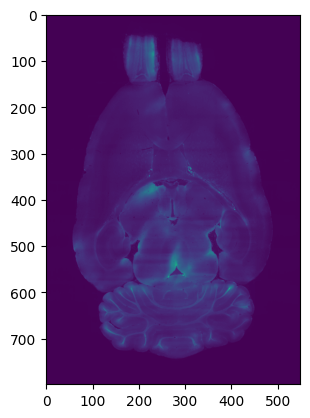

In [8]:
#Load the downsampled png image.
png_filename = ds_folder + slice_identifier + '.png'

# Load the downsampled image
ds_img = io.imread(png_filename)
plt.imshow(ds_img)

# Get the list of all png files in the folder
png_identifiers = [f[:-4] for f in os.listdir(ds_folder) if f.endswith('.png')]

ds_zdim = len(png_identifiers)
ds_zdim

# assert ds_zdim == fs_zdim # Not yet ...  wait until downsampling images is complete.

2766

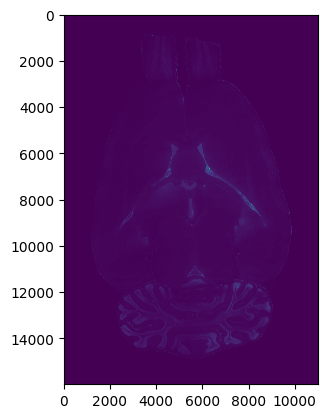

In [9]:
#Load an original-resolution tif image.

tif_filename = fullres_folder + slice_identifier + '.tif'

# Load the fullsized tif
fs_img = io.imread(tif_filename)
plt.imshow(fs_img)

fs_zdim = len(identifiers)
fs_zdim

In [10]:
def map_img_to_label(img_identifier, identifier_list, label_volume):

    '''Take an image name (identifier), 
    and map this to the corresponding slice
      of the label volume'''
    
    img_zdim = fs_zdim # This may need to be changed if we use downsampled images that are also downsampled in z.

    # Get the index of the identifier in the list of identifiers
    idx = identifier_list.index(img_identifier)
 
    # Get the corresponding slice of the label volume by interpolating the index
    label_ind = int(idx * lab_zdim / img_zdim)
    label_slice = label_volume[:,:,label_ind] # Note that

    # Return a tuple containing the image index and the corresponding label index, along with that slice of the label volume
    return  (idx,label_ind), label_slice


1120 294


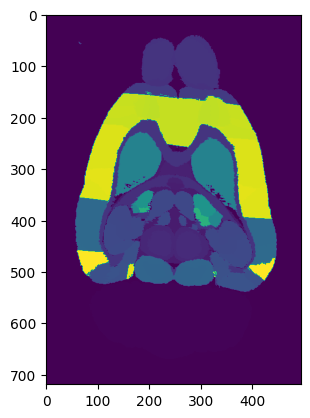

In [11]:
# Get the index of this image with respect to
(img_ind, lab_ind), this_atlas_slice = map_img_to_label(slice_identifier, identifiers, labels)
print(img_ind, lab_ind)
plt.imshow(this_atlas_slice)

<function matplotlib.pyplot.show(close=None, block=None)>

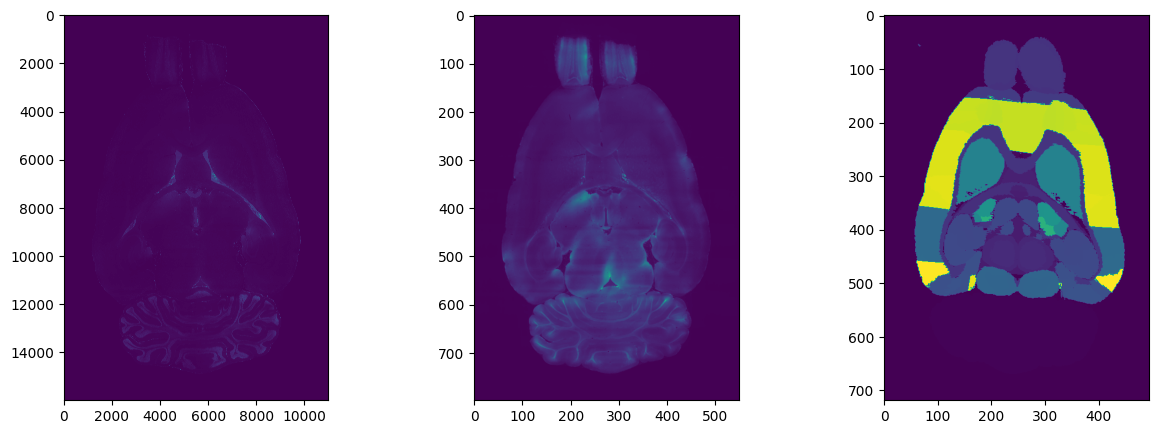

In [12]:

# Matplotlib subplot figure to compare 3 plt.imshow plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(fs_img)
ax2.imshow(ds_img)  
ax3.imshow(this_atlas_slice)    
plt.show

(719, 495, 728)


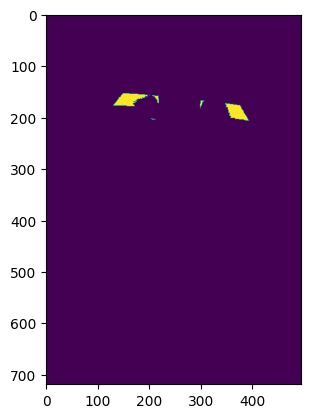

In [13]:
# For a given int value of the label, return a mask of the same shape as the image
def get_mask_from_label(label, labels):
    mask = labels == label
    return mask 

# Example usage:
mask = get_mask_from_label(406, labels)
print(mask.shape)
plt.imshow(mask[:,:,lab_ind])


(799, 549, 728)
(799, 549)


<function matplotlib.pyplot.show(close=None, block=None)>

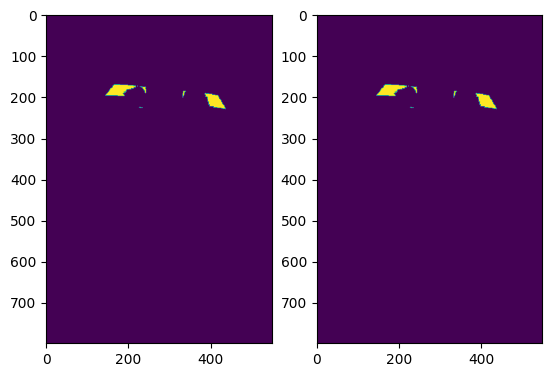

In [14]:
# Scale up the mask to be compatible with both the downsampled image
def scale_mask(mask, ds_img):
    '''Scale up the mask  to be compatible with both the downsampled image
    and the fullsized image
    Should work on either a 2d or 3d mask

    '''
    mask = transform.resize(mask, ds_img.shape, order=0, preserve_range=True)


    return mask

# Use it for the mask we just created with the downsampled image
scaled_mask_vol = scale_mask(mask, ds_img)

scaled_mask_img = scale_mask(mask[:,:,lab_ind], ds_img)

print(scaled_mask_vol.shape)    
print(scaled_mask_img.shape)    

# Verify it's returnbing what I expect:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(scaled_mask_vol[:,:,lab_ind])
ax2.imshow(scaled_mask_img)  
# ax3.imshow(this_atlas_slice)    
plt.show


In [15]:


# # Get the slice of the mask for the corresponding slice of the image, using map_img_to_label
# scaled_mask_slice = map_img_to_label(slice_identifier, identifiers, scaled_mask)

# print(scaled_mask_slice.shape)
# plt.imshow(scaled_mask_slice[:,:])




In [16]:
# Use it for the mask we just created with the fullsize image
# scaled_mask = scale_mask(mask, fs_img)
# scaled_mask.shape
# plt.imshow(scaled_mask[:,:,300])

In [17]:
# Scale up the mask and apply mask to the image
'''
This is only if we want to apply the scaling WHILE also doing the masking...
'''

def apply_mask_to_img(img, mask):
    '''Scale up the mask and apply mask to the image'''

    # First check if the provided mask is 2d or 3d, and extract slice if 3d
    if len(mask.shape) == 2:
        scaled_mask = scale_mask(mask, img)
    elif len(mask.shape) == 3:
        scaled_mask = scale_mask(mask[:,:,lab_ind], img)    
    
    img = img * scaled_mask
    return img

# def apply_mask_slice_to_img(img, mask):
#     '''Scale up the slice of the mask to the image'''
    
#     img = img * scaled_mask
#     return img

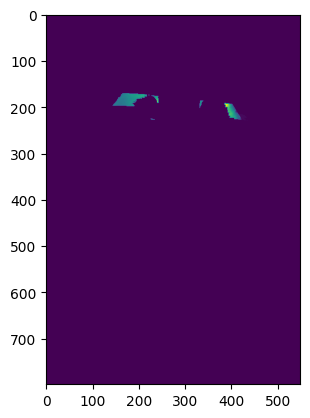

In [18]:
# Use it for the mask we just created with the downsampled image
masked_ds_img = apply_mask_to_img(ds_img, mask)
plt.imshow(masked_ds_img)


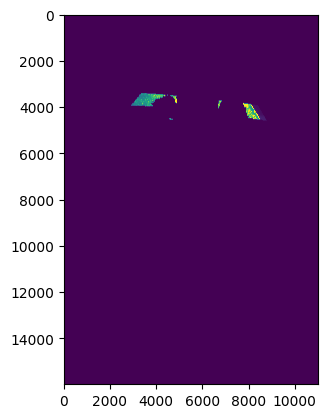

In [19]:
# Use it for the mask we just created with the full-sized image
masked_fs_img = apply_mask_to_img(fs_img, mask)
# Plot this masked image, enahncing the display range to show the masked region
plt.imshow(masked_fs_img, vmin=0, vmax=1000)


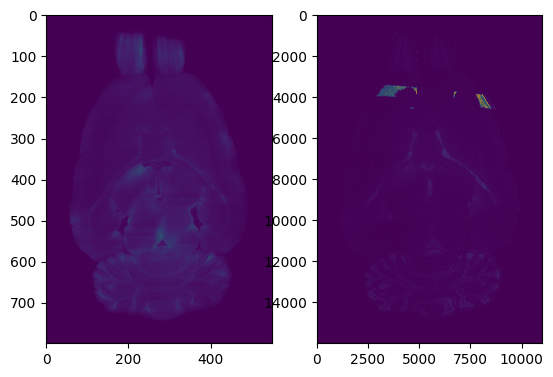

In [20]:
# Make a two-subplot imshow() plot to compare downsampled and full-sized images.
# In both cases, plot the scaled mask over each image with transparency.

# Matplotlib subplot figure to compare 2 plt.imshow plots
fig, (ax1, ax2) = plt.subplots(1, 2)  

# Overlay masked_ds_img on ds_img
ax1.imshow(ds_img)
ax1.imshow(masked_ds_img, alpha=0.5, vmin=0, vmax=1000)

# Overlay masked_ds_img on ds_img, highlighting the masked region
ax2.imshow(fs_img)
ax2.imshow(masked_fs_img, alpha=0.5, vmin=0, vmax=1000)
   



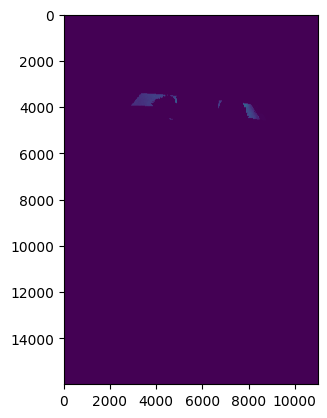

In [21]:
# Now load the corresponding fos image, and apply the same mask to it.


# Load the fos image
fos_filename = fos_folder + slice_identifier + '.tif'
fos_img = io.imread(fos_filename)
plt.imshow(fos_img, vmin=0, vmax=1000)

# Apply the mask to the fos image
masked_fos_img = apply_mask_to_img(fos_img, mask)

# Plot this masked image, enahncing the display range to show the masked region 
plt.imshow(masked_fos_img, vmin=0, vmax=1000)



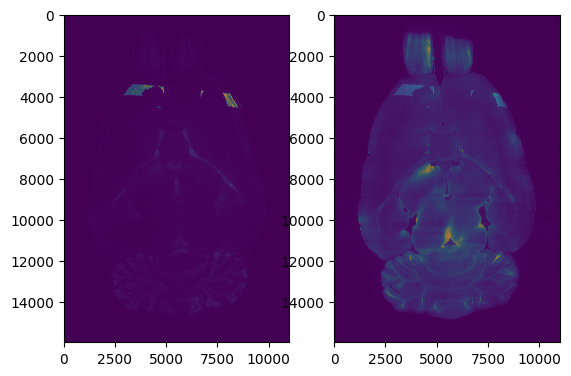

In [22]:
# Matplotlib subplot figure to compare 2 plt.imshow plots
fig, (ax1, ax2) = plt.subplots(1, 2)  

# Overlay masked_ds_img on ds_img, highlighting the masked region
ax1.imshow(fs_img)
ax1.imshow(masked_fs_img, alpha=0.5, vmin=0, vmax=1000)

# Overlay masked_ds_img on ds_img, highlighting the masked region
ax2.imshow(fos_img, vmin=0, vmax=1000)
ax2.imshow(masked_fos_img, alpha=0.5, vmin=0, vmax=500)